# Drawing decision boundaries

## Step 1: Imports and data loading
First, we need to import:
- `numpy`
- `matplotlib.pyplot` to draw the plots
- `sklearn` to have the data and decision boundary display utilities

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.preprocessing import StandardScaler, QuantileTransformer

Then, we import the `meatcube2` package to obtain the models

In [18]:
# as the code is loaded from a subfolder, we use the following snippet to add meatcube2 to the import path
# for a normal usage with meatcube2 installed, the two following lines are unnecessary
import sys, os
try:
    current_folder = os.path.dirname(__file__) # normal way
except NameError:
    current_folder = globals()['_dh'][0] # jupyter notebook way
sys.path.append(os.path.join(current_folder, '../..'))

# we load meatcube2 
from meatcube2.models.meatcube_torch import MeATCubeCB
from meatcube2.models.ct_coat import CtCoAT
from meatcube2.models.ct_coat_naive import CtCoAT as CtCoATNaive
from meatcube2.models.AbstractEnergyBasedClassifier import ACaseBaseEnergyClassifier

We also import `scipy` to define some similarity measures:

In [19]:
from scipy.linalg import norm
from scipy.spatial.distance import euclidean, cosine, correlation, braycurtis, hamming
def euclidean_sim(x1,x2):
    return np.exp(-euclidean(x1,x2))
def cosine_sim(x1,x2):
    return np.exp(-cosine(x1,x2))
def correlation_sim(x1,x2):
    return np.exp(-correlation(x1,x2))
def hamming_sim(x1,x2):
    return np.exp(-hamming(x1,x2))
def radius_sim(x1,x2):
    return np.exp(-abs(norm(x1)-norm(x2)))
def class_equality_sim(y1,y2):
    return np.equal(y1,y2).astype(float)

We also load some additional models to compare to:

In [20]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

Finally, we can load the data (here we use some `sklearn` artificial datasets, but anything goes):

In [21]:
from sklearn.datasets import make_circles, make_classification, make_moons

# some linearly separable data with added noise
X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)


# our three datasets
dataset_names = [
    "Moons",
    "Circles",
    "Line",
]
datasets = [
    make_moons(noise=0.3, random_state=0),
    make_circles(noise=0.2, factor=0.5, random_state=1),
    linearly_separable,
]

## Step 2: Defining the models

## Step 3A: Drawing the boundary of an estimator
We can draw the boundary of a single MeATCube model.

First, let us define the model. For good measure, we equip it with scaling.
It is defined like many other `sklearn` classifiers, and is compatible with scalers and other utilities.
The two necessary parameters are the similarity on the situation (or input) space `sim_X` and the one on the outcome (or output) space `sim_y` .
Other parameters are dedicated to more advanced uses, so we can ignore them.

In [22]:
name = "MeATCube ($\sigma_X$: Euclidean, $\sigma_y$: class)"
clf = MeATCubeCB(euclidean_sim, class_equality_sim)
clf = make_pipeline(StandardScaler(), clf)

We then split the data, and use the training set to define the case base using the `.fit` method:

In [23]:
# Split the data
(X, y), dataset_name = datasets[0], dataset_names[0]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)

# Use the train set as the case base
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('meatcubecb',
                 MeATCubeCB(sim_X=<function euclidean_sim at 0x76712cd8c790>,
                            sim_y=<function class_equality_sim at 0x767136506d40>))])

Finally, we use `DecisionBoundaryDisplay` to plot the decision boundary.

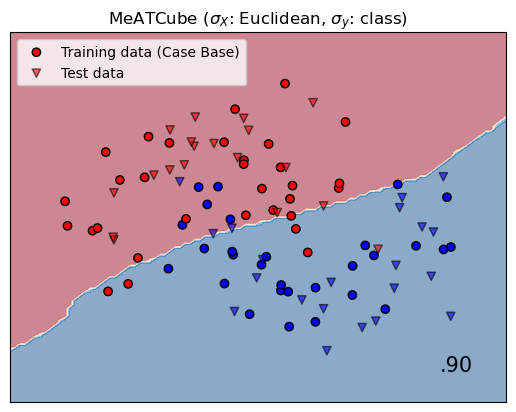

In [24]:
# Prepare the display
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])
plt.figure()
ax = plt.gca()

# get the score to display in the graph
score = clf.score(X_test, y_test)

# Plot the decision boundary
DecisionBoundaryDisplay.from_estimator(
    clf, X, cmap=cm, alpha=0.5, ax=ax, eps=0.5, #grid_resolution=500
)

# Plot the training points
ax.scatter(
    X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k",
    label="Training data (Case Base)"
)

# Plot the testing points
ax.scatter(
    X_test[:, 0],
    X_test[:, 1],
    c=y_test,
    cmap=cm_bright,
    edgecolors="k",
    alpha=0.6,
    marker="v",
    label="Test data"
)

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(name)

# display additional information
ax.text(
    x_max - 0.3,
    y_min + 0.3,
    ("%.2f" % score).lstrip("0"),
    size=15,
    horizontalalignment="right",
)
plt.legend()

# We are done !
plt.show()

## Step 3B: Comparing boundaries with other estimators
It is often useful to display more than one dataset or model, for comparison. We can do so by iterating on the previous code.

First, let us define the MeATCube and CtCoAT models, as well as other models to compare to.
They are defined like many other `sklearn` classifiers.
The two necessary parameters are the similarity on the situation (or input) space `sim_X` and the one on the outcome (or output) space `sim_y` .
Other parameters are dedicated to more advanced uses, so we can ignore them.

In [25]:
names = [
    "MeATCube \n($\sigma_X$: Euclidean, $\sigma_y$: class)",
    "MeATCube \n($\sigma_X$: Cosine, $\sigma_y$: class)",
    # "MeATCube \n($\sigma_X$: Radius w.r.t (0, 0), $\sigma_y$: class)",
    "MeATCube \n($\sigma_X$: Correlation, $\sigma_y$: class)",
    "MeATCube \n($\sigma_X$: Hamming, $\sigma_y$: class)",
    "CtCoat \n($\sigma_X$: Euclidean, $\sigma_y$: class)",
    # "CtCoat non-normalized \n($\sigma_X$: Euclidean, $\sigma_y$: class)",
    #"CtCoAT naive \n($\sigma_X$: Euclidean, $\sigma_y$: class)",
    "Nearest Neighbors \n($n=3$)",
    "Linear SVM",
    # "RBF SVM",
    # "Gaussian Process",
    "Decision Tree \n(max_depth=5)",
]

classifiers = [
    MeATCubeCB(euclidean_sim, class_equality_sim, precompute_sim_matrix=True),
    MeATCubeCB(cosine_sim, class_equality_sim, precompute_sim_matrix=True),
    # MeATCubeCB(radius_sim, class_equality_sim),
    MeATCubeCB(correlation_sim, class_equality_sim, precompute_sim_matrix=True),
    MeATCubeCB(hamming_sim, class_equality_sim, precompute_sim_matrix=True),
    CtCoAT(euclidean_sim, class_equality_sim, precompute_sim_matrix=True),
    # CtCoAT(euclidean_sim, class_equality_sim, normalize=False),
    #CtCoATNaive(euclidean_sim, class_equality_sim),
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42),
    # SVC(gamma=2, C=1, random_state=42),
    # GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
]

In [26]:
# We import tqdm to display a progress bar
from tqdm.notebook import tqdm

In [27]:
%%script echo skipping
with tqdm(total = len(datasets)*len(classifiers)) as progress:
    figure = plt.figure(figsize=(27, 9))
    i = 1
    # iterate over datasets
    for ds_cnt, (ds, ds_name) in enumerate(zip(datasets, dataset_names)):  
        progress.set_description(ds_name)
        #print(ds_cnt/len(datasets))
        # preprocess dataset, split into training and test part
        X, y = ds
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.4, random_state=42
        )

        x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
        y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

        # just plot the dataset first
        cm = plt.cm.RdBu
        cm_bright = ListedColormap(["#FF0000", "#0000FF"])
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k",
                label="Training data")
        # Plot the testing points
        ax.scatter(
            X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, #edgecolors="k",
                marker="v",
                label="Test data"
        )
        if ds_cnt == 0:
            ax.set_title("Input data: " + ds_name)
            ax.legend()
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        i += 1

        # iterate over classifiers
        for name, clf in zip(names, classifiers):
            progress.update()
            progress.set_description(ds_name + ", clf: " + name)
            ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

            clf_ = make_pipeline(StandardScaler(), clf)
            clf_.fit(X_train, y_train)
            score = clf_.score(X_test, y_test)
            #QuantileTransformer(n_quantiles=10).fit_transform(score)
            DecisionBoundaryDisplay.from_estimator(
                clf_, X, cmap=cm, alpha=0.5, ax=ax, eps=0.5, #grid_resolution=500
            )

            

            # Plot the testing points
            scatter = ax.scatter(
                X_test[:, 0],
                X_test[:, 1],
                c=y_test,
                cmap=cm_bright,
                #edgecolors="k",
                alpha=0.6,
                marker="v",
                label="Test data"
            )

            # Plot the CB
            if isinstance(clf, ACaseBaseEnergyClassifier):
                _X = clf_.steps[0][1].inverse_transform(clf._X)
                _y = clf._y
                scatter = ax.scatter(
                    x=_X[:, 0],
                    y=_X[:, 1],
                    c=_y,
                    cmap=cm_bright,
                    edgecolors="k",
                    alpha=0.6,
                    marker="o",
                    label="CB"
                )

            # display additional information

            ax.set_xlim(x_min, x_max)
            ax.set_ylim(y_min, y_max)
            ax.set_xticks(())
            ax.set_yticks(())
            if ds_cnt == 0:
                ax.set_title(name)
            ax.text(
                x_max - 0.3,
                y_min + 0.3,
                ("%.2f" % score).lstrip("0"),
                size=15,
                horizontalalignment="right",
            )
            
            # produce a legend with a cross-section of sizes from the scatter
            if isinstance(clf, ACaseBaseEnergyClassifier):
                legend_elements = [
                    plt.Line2D([0], [0], marker='o', color='black', label='CB', markersize=10, linestyle='None'),
                    plt.Line2D([0], [0], marker='v', color='black', label='Test', markersize=10, linestyle='None')
                ]
            else:
                legend_elements = [
                    plt.Line2D([0], [0], marker='v', color='black', label='Test', markersize=10, linestyle='None')
                ]
            ax.legend(handles=legend_elements, title="Data")
            i += 1

plt.tight_layout()
plt.show()

skipping


A similar result can be obtained with the function `meatcube2.plotting.compare.plot_dataset_model_grid`:

  0%|          | 0/24 [00:00<?, ?it/s]

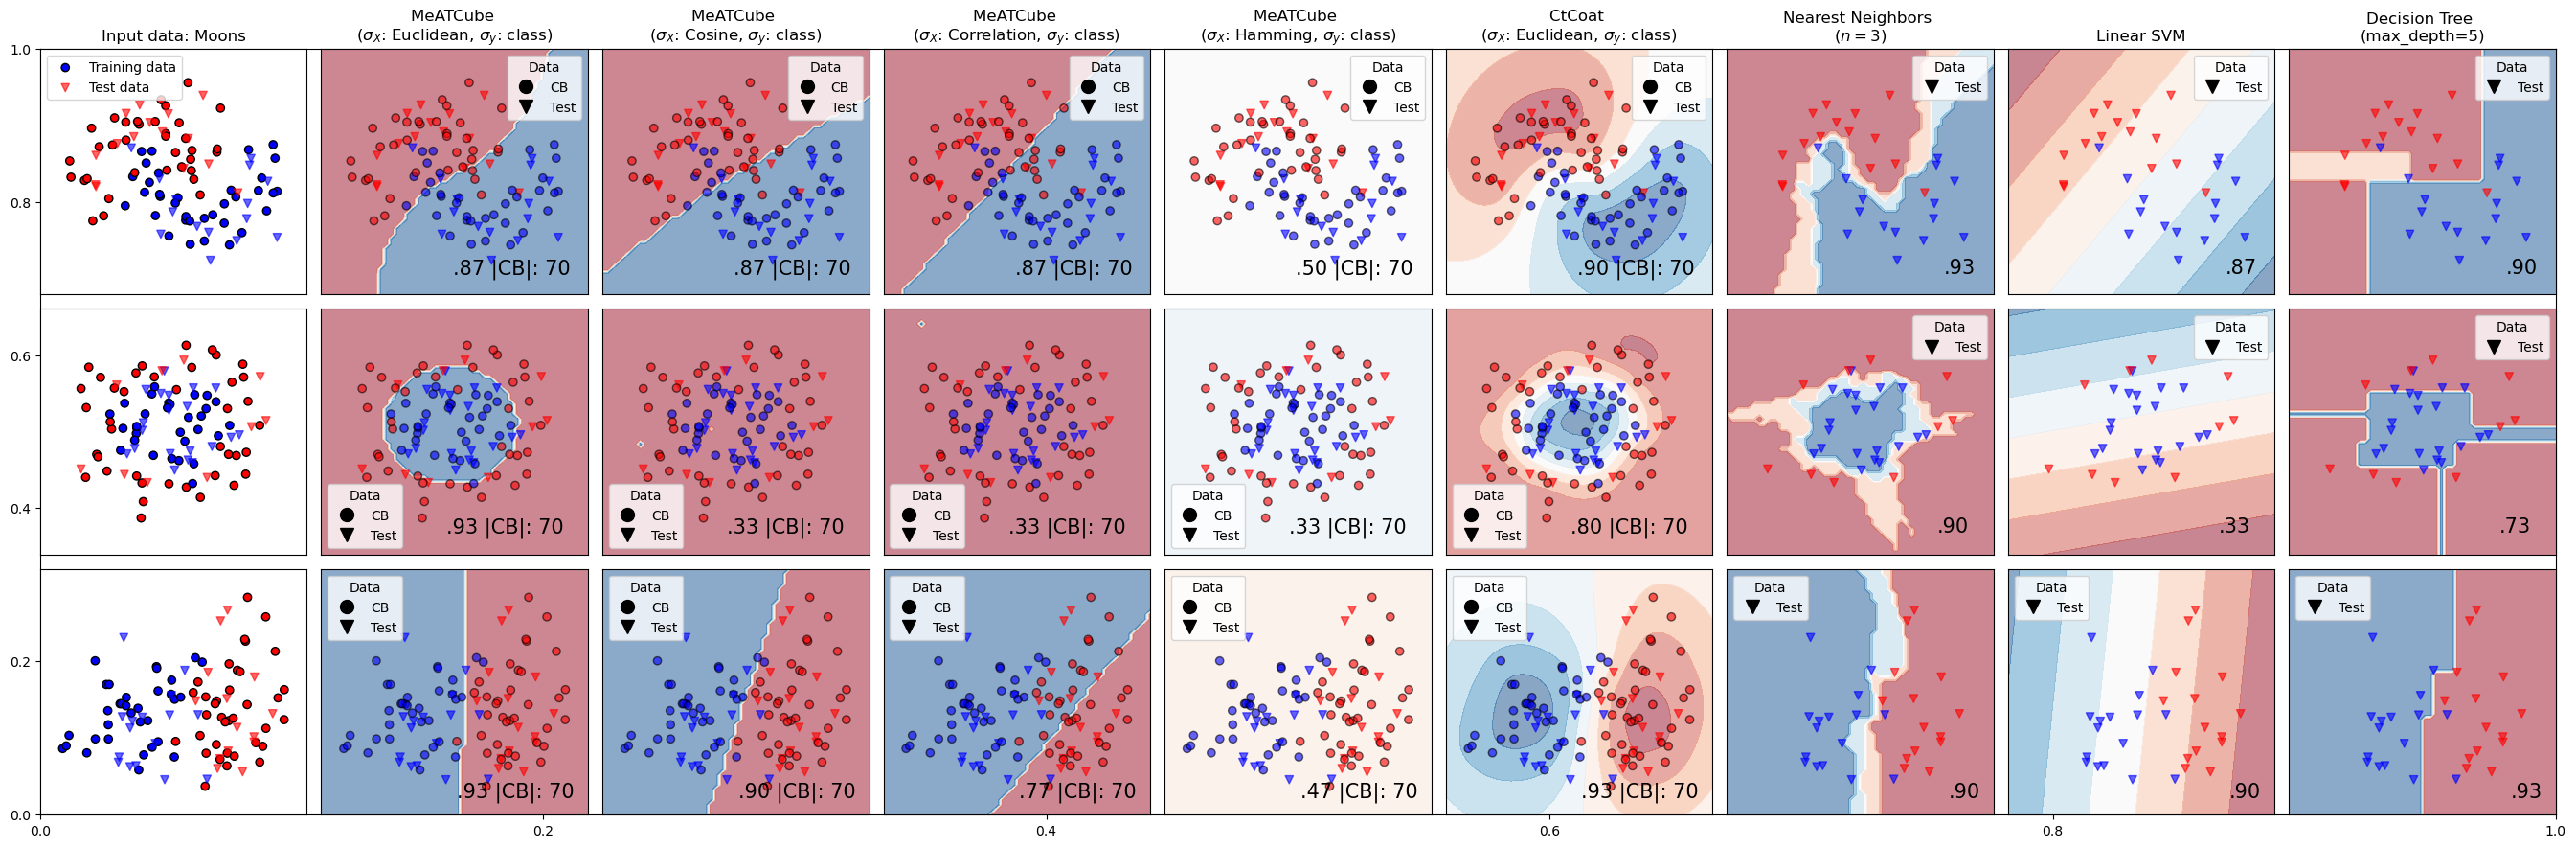

In [28]:
import importlib 
try: importlib.reload(sys.modules['meatcube2.plotting.compare'])
except KeyError: pass
from meatcube2.plotting.compare import plot_dataset_model_grid_autosplit


plot_dataset_model_grid_autosplit(datasets, dataset_names, classifiers, names, progress_bar="notebook")

plt.tight_layout()
plt.show()

## Step 4: Compression

In [29]:
from meatcube2.cb_maintenance import CBClassificationMaintainer

maintainer = CBClassificationMaintainer(
    MeATCubeCB(euclidean_sim, class_equality_sim, precompute_sim_matrix=True),
    memorize_estimators=True,
    patience=-1)

`memorize_estimators=True` allows to keep a version of the CB in memory at each step, that we will use to plot the evolution of the CB.

In [30]:
from meatcube2.plotting.compare import animate_dataset_model_grid_on_models, split_datasets
from IPython.display import HTML

dataset, dataset_name = datasets[:1], dataset_names[:1]
dataset_split = split_datasets(dataset, True)
(X_train, y_train), (X_ref, y_ref), (X_test, y_test) = dataset_split[0]
maintainer.fit(X_train, y_train, X_ref, y_ref)

We can produce an annimation of the process

In [31]:
ani, _, _= animate_dataset_model_grid_on_models(
    dataset_split,
    dataset_name,
    maintainer.estimators_,
    classifiers_names=[f"step {i} (accuracy on ref set: {maintainer.scores_[i]:.3%})" for i in range(len(maintainer.estimators_))],
    fit_estimators=False,
    progress_bar="notebook")
#plt.show()
html = HTML(ani.to_jshtml())
plt.clf()
html

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

<Figure size 600x300 with 0 Axes>

In [32]:
maintainer.best_score_

1.0